In [2]:
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Load the dataset
dataset = torch.load("HAM10000Skin_Cancer_Balanced.pt")

# Extract images and metadata
images = dataset["images"]
metadata = dataset["metadata"]

# Extract labels (assume dx is stored in the first column of metadata)
labels = metadata[:, 0].long()

# Create a DataFrame for clinical data (excluding labels)
clinical_data = pd.DataFrame(metadata[:, 1:].numpy(), columns=[
    f"clinical_{i}" for i in range(1, metadata.size(1))
])

classnames = classname = [
    "Benign lesions of the keratosis",
    "Basal cell carcinoma",
    "Dermatofibroma",
    "Melanoma",
    "Melanocylabels",
    "tic nevi",
    "Vascular lesions",
    "Actinic keratoses"
]
label_dict = {abbr: name for abbr, name in zip(["bkl", "bcc", "df", "mel", "nv", "vasc", "akiec"], classnames)}

# Split data into train and test
train_ratio = 0.85
train_size = int(train_ratio * len(images))
test_size = len(images) - train_size

indices = torch.randperm(len(images)).tolist()  # Shuffle indices
train_indices, test_indices = indices[:train_size], indices[train_size:]

# Split data
X_train_images = images[train_indices]
X_test_images = images[test_indices]
X_train_clin = clinical_data.iloc[train_indices]
X_test_clin = clinical_data.iloc[test_indices]
y_train = labels[train_indices]
y_test = labels[test_indices]

# Create a custom dataset class
class SkinCancerDataset(Dataset):
    def __init__(self, images, clinical_data, labels):
        self.images = images
        self.clinical_data = clinical_data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "image": self.images[idx],
            "clinical_data": torch.tensor(self.clinical_data.iloc[idx].values, dtype=torch.float32),
            "label": self.labels[idx]
        }

# Create datasets
train_dataset = SkinCancerDataset(X_train_images, X_train_clin, y_train)
test_dataset = SkinCancerDataset(X_test_images, X_test_clin, y_test)

# Create dataloaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print summary
print(f"Train size: {len(train_dataset)}, Test size: {len(test_dataset)}")
print(f"Classnames: {classnames}")
print(f"Label dictionary: {label_dict}")


C:\Users\dasad\AppData\Local\Temp\ipykernel_17252\3088060718.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  dataset = torch.load("HAM10000Skin_Cancer_Balanced.pt")


Train size: 17850, Test size: 3150
Classnames: ['Benign lesions of the keratosis', 'Basal cell carcinoma', 'Dermatofibroma', 'Melanoma', 'Melanocylabels', 'tic nevi', 'Vascular lesions', 'Actinic keratoses']
Label dictionary: {'bkl': 'Benign lesions of the keratosis', 'bcc': 'Basal cell carcinoma', 'df': 'Dermatofibroma', 'mel': 'Melanoma', 'nv': 'Melanocylabels', 'vasc': 'tic nevi', 'akiec': 'Vascular lesions'}


In [3]:
import torch
import torch.nn as nn

class WeightedResnet(nn.Module):
    def __init__(self, in_channels, num_classes, initial_res_weights=0.001):
        super(WeightedResnet, self).__init__()

        # Initialize res_weights as a learnable parameter
        self.res_weights = nn.Parameter(torch.tensor(initial_res_weights, dtype=torch.float32))

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True)
        )
        self.res1 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
        )
        self.res2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(128)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
        )
        self.res3 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.1),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256)
        )

        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.res4 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1, bias=False),
            nn.Dropout(0.1),
            nn.BatchNorm2d(512)
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.Dropout(0.1),
            nn.Linear(256, 512)
        )

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.res1(x) + self.res_weights * x

        x = self.conv3(x)
        x = self.res2(x) + self.res_weights * x

        x = self.conv4(x)
        x = self.res3(x) + self.res_weights * x

        x = self.conv5(x)
        x = self.res4(x) + self.res_weights * x

        x = self.classifier(x)
        x = self.softmax(x)

        return x


In [4]:
class ClinicalNN(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(ClinicalNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 256)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x



In [5]:
class BilinearFusion(nn.Module):
    def __init__(self, image_model, clinical_model, num_classes, image_feature_dim=512, clinical_feature_dim=256):
        super(BilinearFusion, self).__init__()
        self.image_model = image_model
        self.clinical_model = clinical_model
        self.bilinear = nn.Bilinear(image_feature_dim, clinical_feature_dim, 256)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, image, clinical):
        image_features = self.image_model(image)
        clinical_features = self.clinical_model(clinical)
        combined_features = self.bilinear(image_features, clinical_features)
        output = self.fc(combined_features)
        return output

Epoch 1/100: 100%|████████████████████████████████████████████████| 279/279 [02:30<00:00,  1.85it/s]


Epoch 1/100
Train Loss: 1.5613, Train Accuracy: 44.22%
Test Loss: 1.1366, Test Accuracy: 57.81%, Test Recall: 57.89%


Epoch 2/100: 100%|████████████████████████████████████████████████| 279/279 [02:45<00:00,  1.68it/s]


Epoch 2/100
Train Loss: 1.0509, Train Accuracy: 60.41%
Test Loss: 1.1505, Test Accuracy: 50.41%, Test Recall: 50.52%


Epoch 3/100: 100%|████████████████████████████████████████████████| 279/279 [02:47<00:00,  1.67it/s]


Epoch 3/100
Train Loss: 0.9607, Train Accuracy: 63.97%
Test Loss: 0.8665, Test Accuracy: 67.30%, Test Recall: 67.21%


Epoch 4/100: 100%|████████████████████████████████████████████████| 279/279 [02:47<00:00,  1.67it/s]


Epoch 4/100
Train Loss: 0.9029, Train Accuracy: 65.98%
Test Loss: 0.9161, Test Accuracy: 66.22%, Test Recall: 66.41%


Epoch 5/100: 100%|████████████████████████████████████████████████| 279/279 [02:47<00:00,  1.66it/s]


Epoch 5/100
Train Loss: 0.8544, Train Accuracy: 67.65%
Test Loss: 0.9038, Test Accuracy: 65.49%, Test Recall: 65.66%


Epoch 6/100: 100%|████████████████████████████████████████████████| 279/279 [02:50<00:00,  1.64it/s]


Epoch 6/100
Train Loss: 0.8227, Train Accuracy: 69.18%
Test Loss: 0.8328, Test Accuracy: 69.11%, Test Recall: 69.06%


Epoch 7/100: 100%|████████████████████████████████████████████████| 279/279 [02:47<00:00,  1.66it/s]


Epoch 7/100
Train Loss: 0.7835, Train Accuracy: 70.31%
Test Loss: 1.0659, Test Accuracy: 62.95%, Test Recall: 62.75%


Epoch 8/100: 100%|████████████████████████████████████████████████| 279/279 [02:47<00:00,  1.67it/s]


Epoch 8/100
Train Loss: 0.7500, Train Accuracy: 71.73%
Test Loss: 0.7726, Test Accuracy: 70.67%, Test Recall: 70.33%


Epoch 9/100: 100%|████████████████████████████████████████████████| 279/279 [02:46<00:00,  1.68it/s]


Epoch 9/100
Train Loss: 0.7090, Train Accuracy: 73.36%
Test Loss: 0.7244, Test Accuracy: 72.67%, Test Recall: 72.62%


Epoch 10/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.68it/s]


Epoch 10/100
Train Loss: 0.6650, Train Accuracy: 74.97%
Test Loss: 0.6858, Test Accuracy: 73.81%, Test Recall: 73.71%


Epoch 11/100: 100%|███████████████████████████████████████████████| 279/279 [02:48<00:00,  1.66it/s]


Epoch 11/100
Train Loss: 0.6279, Train Accuracy: 76.57%
Test Loss: 0.6460, Test Accuracy: 75.94%, Test Recall: 75.86%


Epoch 12/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.68it/s]


Epoch 12/100
Train Loss: 0.6030, Train Accuracy: 77.25%
Test Loss: 0.6520, Test Accuracy: 76.95%, Test Recall: 76.87%


Epoch 13/100: 100%|███████████████████████████████████████████████| 279/279 [02:45<00:00,  1.68it/s]


Epoch 13/100
Train Loss: 0.5709, Train Accuracy: 78.78%
Test Loss: 0.6904, Test Accuracy: 75.65%, Test Recall: 75.59%


Epoch 14/100: 100%|███████████████████████████████████████████████| 279/279 [02:48<00:00,  1.66it/s]


Epoch 14/100
Train Loss: 0.5359, Train Accuracy: 79.80%
Test Loss: 0.5849, Test Accuracy: 80.06%, Test Recall: 80.01%


Epoch 15/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.67it/s]


Epoch 15/100
Train Loss: 0.4915, Train Accuracy: 81.90%
Test Loss: 0.5228, Test Accuracy: 83.08%, Test Recall: 83.07%


Epoch 16/100: 100%|███████████████████████████████████████████████| 279/279 [02:47<00:00,  1.67it/s]


Epoch 16/100
Train Loss: 0.4594, Train Accuracy: 83.07%
Test Loss: 0.6277, Test Accuracy: 78.89%, Test Recall: 78.77%


Epoch 17/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.67it/s]


Epoch 17/100
Train Loss: 0.4443, Train Accuracy: 83.38%
Test Loss: 0.5315, Test Accuracy: 80.29%, Test Recall: 80.30%


Epoch 18/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.68it/s]


Epoch 18/100
Train Loss: 0.4065, Train Accuracy: 85.06%
Test Loss: 0.6123, Test Accuracy: 79.40%, Test Recall: 79.39%


Epoch 19/100: 100%|███████████████████████████████████████████████| 279/279 [02:48<00:00,  1.65it/s]


Epoch 19/100
Train Loss: 0.3933, Train Accuracy: 85.44%
Test Loss: 0.5790, Test Accuracy: 79.24%, Test Recall: 79.09%


Epoch 20/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.67it/s]


Epoch 20/100
Train Loss: 0.3727, Train Accuracy: 86.30%
Test Loss: 0.4008, Test Accuracy: 86.70%, Test Recall: 86.64%


Epoch 21/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.68it/s]


Epoch 21/100
Train Loss: 0.3541, Train Accuracy: 87.03%
Test Loss: 0.8247, Test Accuracy: 73.49%, Test Recall: 73.71%


Epoch 22/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.68it/s]


Epoch 22/100
Train Loss: 0.3181, Train Accuracy: 88.40%
Test Loss: 0.7197, Test Accuracy: 78.25%, Test Recall: 78.39%


Epoch 23/100: 100%|███████████████████████████████████████████████| 279/279 [02:45<00:00,  1.68it/s]


Epoch 23/100
Train Loss: 0.3044, Train Accuracy: 89.08%
Test Loss: 0.3629, Test Accuracy: 87.78%, Test Recall: 87.69%


Epoch 24/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.67it/s]


Epoch 24/100
Train Loss: 0.2801, Train Accuracy: 89.72%
Test Loss: 0.3788, Test Accuracy: 87.11%, Test Recall: 87.03%


Epoch 25/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.68it/s]


Epoch 25/100
Train Loss: 0.2831, Train Accuracy: 89.88%
Test Loss: 0.4650, Test Accuracy: 86.06%, Test Recall: 86.01%


Epoch 26/100: 100%|███████████████████████████████████████████████| 279/279 [02:47<00:00,  1.67it/s]


Epoch 26/100
Train Loss: 0.2492, Train Accuracy: 91.13%
Test Loss: 0.2763, Test Accuracy: 91.56%, Test Recall: 91.46%


Epoch 27/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.68it/s]


Epoch 27/100
Train Loss: 0.2486, Train Accuracy: 91.05%
Test Loss: 0.3689, Test Accuracy: 87.87%, Test Recall: 87.77%


Epoch 28/100: 100%|███████████████████████████████████████████████| 279/279 [02:48<00:00,  1.66it/s]


Epoch 28/100
Train Loss: 0.2389, Train Accuracy: 91.36%
Test Loss: 0.3028, Test Accuracy: 90.79%, Test Recall: 90.76%


Epoch 29/100: 100%|███████████████████████████████████████████████| 279/279 [02:47<00:00,  1.66it/s]


Epoch 29/100
Train Loss: 0.2242, Train Accuracy: 92.07%
Test Loss: 1.0161, Test Accuracy: 71.90%, Test Recall: 71.80%


Epoch 30/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.68it/s]


Epoch 30/100
Train Loss: 0.2149, Train Accuracy: 92.54%
Test Loss: 0.3020, Test Accuracy: 90.29%, Test Recall: 90.20%


Epoch 31/100: 100%|███████████████████████████████████████████████| 279/279 [02:45<00:00,  1.68it/s]


Epoch 31/100
Train Loss: 0.1941, Train Accuracy: 93.06%
Test Loss: 0.3225, Test Accuracy: 90.89%, Test Recall: 90.80%


Epoch 32/100: 100%|███████████████████████████████████████████████| 279/279 [02:47<00:00,  1.67it/s]


Epoch 32/100
Train Loss: 0.2016, Train Accuracy: 92.83%
Test Loss: 0.2523, Test Accuracy: 92.25%, Test Recall: 92.18%


Epoch 33/100: 100%|███████████████████████████████████████████████| 279/279 [02:45<00:00,  1.68it/s]


Epoch 33/100
Train Loss: 0.1833, Train Accuracy: 93.48%
Test Loss: 0.4588, Test Accuracy: 85.21%, Test Recall: 85.06%


Epoch 34/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.68it/s]


Epoch 34/100
Train Loss: 0.1857, Train Accuracy: 93.41%
Test Loss: 0.2554, Test Accuracy: 92.44%, Test Recall: 92.34%


Epoch 35/100: 100%|███████████████████████████████████████████████| 279/279 [02:45<00:00,  1.69it/s]


Epoch 35/100
Train Loss: 0.1698, Train Accuracy: 94.03%
Test Loss: 0.2254, Test Accuracy: 94.38%, Test Recall: 94.28%


Epoch 36/100: 100%|███████████████████████████████████████████████| 279/279 [02:47<00:00,  1.67it/s]


Epoch 36/100
Train Loss: 0.1645, Train Accuracy: 94.35%
Test Loss: 0.2478, Test Accuracy: 93.17%, Test Recall: 93.08%


Epoch 37/100: 100%|███████████████████████████████████████████████| 279/279 [02:47<00:00,  1.67it/s]


Epoch 37/100
Train Loss: 0.1577, Train Accuracy: 94.50%
Test Loss: 0.3438, Test Accuracy: 89.40%, Test Recall: 89.33%


Epoch 38/100: 100%|███████████████████████████████████████████████| 279/279 [02:44<00:00,  1.70it/s]


Epoch 38/100
Train Loss: 0.1749, Train Accuracy: 94.01%
Test Loss: 0.3060, Test Accuracy: 91.37%, Test Recall: 91.22%


Epoch 39/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.68it/s]


Epoch 39/100
Train Loss: 0.1356, Train Accuracy: 95.20%
Test Loss: 0.2252, Test Accuracy: 93.90%, Test Recall: 93.79%


Epoch 40/100: 100%|███████████████████████████████████████████████| 279/279 [02:47<00:00,  1.67it/s]


Epoch 40/100
Train Loss: 0.1540, Train Accuracy: 94.66%
Test Loss: 0.2385, Test Accuracy: 93.14%, Test Recall: 93.09%


Epoch 41/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.67it/s]


Epoch 41/100
Train Loss: 0.1402, Train Accuracy: 95.24%
Test Loss: 0.2374, Test Accuracy: 93.68%, Test Recall: 93.63%


Epoch 42/100: 100%|███████████████████████████████████████████████| 279/279 [02:47<00:00,  1.66it/s]


Epoch 42/100
Train Loss: 0.1416, Train Accuracy: 95.19%
Test Loss: 0.2977, Test Accuracy: 91.75%, Test Recall: 91.63%


Epoch 43/100: 100%|███████████████████████████████████████████████| 279/279 [02:45<00:00,  1.68it/s]


Epoch 43/100
Train Loss: 0.1483, Train Accuracy: 94.58%
Test Loss: 0.2778, Test Accuracy: 92.73%, Test Recall: 92.65%


Epoch 44/100: 100%|███████████████████████████████████████████████| 279/279 [02:45<00:00,  1.68it/s]


Epoch 44/100
Train Loss: 0.1334, Train Accuracy: 95.28%
Test Loss: 0.3541, Test Accuracy: 90.13%, Test Recall: 90.05%


Epoch 45/100: 100%|███████████████████████████████████████████████| 279/279 [02:45<00:00,  1.68it/s]


Epoch 45/100
Train Loss: 0.1411, Train Accuracy: 95.15%
Test Loss: 0.4251, Test Accuracy: 87.37%, Test Recall: 87.34%


Epoch 46/100: 100%|███████████████████████████████████████████████| 279/279 [02:48<00:00,  1.66it/s]


Epoch 46/100
Train Loss: 0.1184, Train Accuracy: 95.78%
Test Loss: 0.2365, Test Accuracy: 93.43%, Test Recall: 93.37%


Epoch 47/100: 100%|███████████████████████████████████████████████| 279/279 [02:45<00:00,  1.69it/s]


Epoch 47/100
Train Loss: 0.1081, Train Accuracy: 96.22%
Test Loss: 0.7274, Test Accuracy: 82.57%, Test Recall: 82.44%


Epoch 48/100: 100%|███████████████████████████████████████████████| 279/279 [02:48<00:00,  1.65it/s]


Epoch 48/100
Train Loss: 0.1013, Train Accuracy: 96.49%
Test Loss: 0.3373, Test Accuracy: 91.97%, Test Recall: 91.92%


Epoch 49/100: 100%|███████████████████████████████████████████████| 279/279 [02:47<00:00,  1.67it/s]


Epoch 49/100
Train Loss: 0.1196, Train Accuracy: 96.00%
Test Loss: 0.2241, Test Accuracy: 94.13%, Test Recall: 94.07%


Epoch 50/100: 100%|███████████████████████████████████████████████| 279/279 [02:45<00:00,  1.69it/s]


Epoch 50/100
Train Loss: 0.0957, Train Accuracy: 96.59%
Test Loss: 0.2448, Test Accuracy: 94.98%, Test Recall: 94.90%


Epoch 51/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.67it/s]


Epoch 51/100
Train Loss: 0.1266, Train Accuracy: 95.94%
Test Loss: 0.4281, Test Accuracy: 89.94%, Test Recall: 89.83%


Epoch 52/100: 100%|███████████████████████████████████████████████| 279/279 [02:45<00:00,  1.68it/s]


Epoch 52/100
Train Loss: 0.1326, Train Accuracy: 95.69%
Test Loss: 0.2840, Test Accuracy: 93.40%, Test Recall: 93.32%


Epoch 53/100: 100%|███████████████████████████████████████████████| 279/279 [02:45<00:00,  1.69it/s]


Epoch 53/100
Train Loss: 0.1198, Train Accuracy: 95.96%
Test Loss: 0.2397, Test Accuracy: 94.38%, Test Recall: 94.26%


Epoch 54/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.68it/s]


Epoch 54/100
Train Loss: 0.0834, Train Accuracy: 97.11%
Test Loss: 0.2536, Test Accuracy: 94.19%, Test Recall: 94.09%


Epoch 55/100: 100%|███████████████████████████████████████████████| 279/279 [02:45<00:00,  1.68it/s]


Epoch 55/100
Train Loss: 0.0865, Train Accuracy: 96.89%
Test Loss: 0.2209, Test Accuracy: 94.86%, Test Recall: 94.78%


Epoch 56/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.67it/s]


Epoch 56/100
Train Loss: 0.0868, Train Accuracy: 97.11%
Test Loss: 0.2531, Test Accuracy: 94.16%, Test Recall: 94.07%


Epoch 57/100: 100%|███████████████████████████████████████████████| 279/279 [02:47<00:00,  1.66it/s]


Epoch 57/100
Train Loss: 0.1095, Train Accuracy: 96.25%
Test Loss: 0.2827, Test Accuracy: 94.10%, Test Recall: 94.00%


Epoch 58/100: 100%|███████████████████████████████████████████████| 279/279 [02:45<00:00,  1.68it/s]


Epoch 58/100
Train Loss: 0.0801, Train Accuracy: 97.25%
Test Loss: 0.4370, Test Accuracy: 89.08%, Test Recall: 89.11%


Epoch 59/100: 100%|███████████████████████████████████████████████| 279/279 [02:51<00:00,  1.62it/s]


Epoch 59/100
Train Loss: 0.0792, Train Accuracy: 97.37%
Test Loss: 0.3453, Test Accuracy: 92.13%, Test Recall: 92.04%


Epoch 60/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.68it/s]


Epoch 60/100
Train Loss: 0.1039, Train Accuracy: 96.67%
Test Loss: 0.2186, Test Accuracy: 94.86%, Test Recall: 94.76%


Epoch 61/100: 100%|███████████████████████████████████████████████| 279/279 [02:47<00:00,  1.67it/s]


Epoch 61/100
Train Loss: 0.0847, Train Accuracy: 97.29%
Test Loss: 0.2764, Test Accuracy: 94.83%, Test Recall: 94.72%


Epoch 62/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.67it/s]


Epoch 62/100
Train Loss: 0.1048, Train Accuracy: 96.61%
Test Loss: 0.1985, Test Accuracy: 95.27%, Test Recall: 95.20%


Epoch 63/100: 100%|███████████████████████████████████████████████| 279/279 [02:45<00:00,  1.68it/s]


Epoch 63/100
Train Loss: 0.0695, Train Accuracy: 97.61%
Test Loss: 0.2363, Test Accuracy: 95.68%, Test Recall: 95.61%


Epoch 64/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.68it/s]


Epoch 64/100
Train Loss: 0.0589, Train Accuracy: 97.88%
Test Loss: 0.3197, Test Accuracy: 94.10%, Test Recall: 94.00%


Epoch 65/100: 100%|███████████████████████████████████████████████| 279/279 [02:45<00:00,  1.69it/s]


Epoch 65/100
Train Loss: 0.1014, Train Accuracy: 96.76%
Test Loss: 0.3797, Test Accuracy: 89.94%, Test Recall: 89.85%


Epoch 66/100: 100%|███████████████████████████████████████████████| 279/279 [02:47<00:00,  1.67it/s]


Epoch 66/100
Train Loss: 0.0659, Train Accuracy: 97.88%
Test Loss: 0.2551, Test Accuracy: 94.44%, Test Recall: 94.36%


Epoch 67/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.68it/s]


Epoch 67/100
Train Loss: 0.0930, Train Accuracy: 97.07%
Test Loss: 0.2546, Test Accuracy: 94.86%, Test Recall: 94.80%


Epoch 68/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.68it/s]


Epoch 68/100
Train Loss: 0.0879, Train Accuracy: 97.42%
Test Loss: 0.2182, Test Accuracy: 95.78%, Test Recall: 95.69%


Epoch 69/100: 100%|███████████████████████████████████████████████| 279/279 [02:45<00:00,  1.68it/s]


Epoch 69/100
Train Loss: 0.0809, Train Accuracy: 97.37%
Test Loss: 0.2090, Test Accuracy: 95.52%, Test Recall: 95.43%


Epoch 70/100: 100%|███████████████████████████████████████████████| 279/279 [02:45<00:00,  1.68it/s]


Epoch 70/100
Train Loss: 0.0622, Train Accuracy: 97.94%
Test Loss: 0.2136, Test Accuracy: 95.71%, Test Recall: 95.65%


Epoch 71/100: 100%|███████████████████████████████████████████████| 279/279 [02:47<00:00,  1.67it/s]


Epoch 71/100
Train Loss: 0.0802, Train Accuracy: 97.54%
Test Loss: 0.2330, Test Accuracy: 94.73%, Test Recall: 94.71%


Epoch 72/100: 100%|███████████████████████████████████████████████| 279/279 [02:45<00:00,  1.69it/s]


Epoch 72/100
Train Loss: 0.0726, Train Accuracy: 97.64%
Test Loss: 0.2077, Test Accuracy: 95.52%, Test Recall: 95.44%


Epoch 73/100: 100%|███████████████████████████████████████████████| 279/279 [02:45<00:00,  1.68it/s]


Epoch 73/100
Train Loss: 0.0523, Train Accuracy: 98.20%
Test Loss: 0.2135, Test Accuracy: 96.03%, Test Recall: 95.94%


Epoch 74/100: 100%|███████████████████████████████████████████████| 279/279 [02:45<00:00,  1.68it/s]


Epoch 74/100
Train Loss: 0.0677, Train Accuracy: 97.65%
Test Loss: 0.1963, Test Accuracy: 95.97%, Test Recall: 95.90%


Epoch 75/100: 100%|███████████████████████████████████████████████| 279/279 [02:45<00:00,  1.69it/s]


Epoch 75/100
Train Loss: 0.0782, Train Accuracy: 97.50%
Test Loss: 0.1919, Test Accuracy: 96.10%, Test Recall: 96.02%


Epoch 76/100: 100%|███████████████████████████████████████████████| 279/279 [02:47<00:00,  1.66it/s]


Epoch 76/100
Train Loss: 0.0529, Train Accuracy: 98.23%
Test Loss: 0.1850, Test Accuracy: 96.51%, Test Recall: 96.43%


Epoch 77/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.68it/s]


Epoch 77/100
Train Loss: 0.0632, Train Accuracy: 97.97%
Test Loss: 0.2753, Test Accuracy: 94.06%, Test Recall: 93.98%


Epoch 78/100: 100%|███████████████████████████████████████████████| 279/279 [02:45<00:00,  1.69it/s]


Epoch 78/100
Train Loss: 0.0844, Train Accuracy: 97.34%
Test Loss: 0.3154, Test Accuracy: 91.75%, Test Recall: 91.72%


Epoch 79/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.67it/s]


Epoch 79/100
Train Loss: 0.0665, Train Accuracy: 97.88%
Test Loss: 0.2757, Test Accuracy: 94.16%, Test Recall: 94.07%


Epoch 80/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.68it/s]


Epoch 80/100
Train Loss: 0.0544, Train Accuracy: 98.18%
Test Loss: 0.2396, Test Accuracy: 96.29%, Test Recall: 96.20%


Epoch 81/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.67it/s]


Epoch 81/100
Train Loss: 0.0685, Train Accuracy: 97.98%
Test Loss: 0.2581, Test Accuracy: 95.71%, Test Recall: 95.63%


Epoch 82/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.68it/s]


Epoch 82/100
Train Loss: 0.0559, Train Accuracy: 98.12%
Test Loss: 0.2094, Test Accuracy: 96.22%, Test Recall: 96.13%


Epoch 83/100: 100%|███████████████████████████████████████████████| 279/279 [02:44<00:00,  1.69it/s]


Epoch 83/100
Train Loss: 0.0514, Train Accuracy: 98.32%
Test Loss: 0.2645, Test Accuracy: 95.37%, Test Recall: 95.27%


Epoch 84/100: 100%|███████████████████████████████████████████████| 279/279 [02:47<00:00,  1.67it/s]


Epoch 84/100
Train Loss: 0.0542, Train Accuracy: 98.21%
Test Loss: 0.2447, Test Accuracy: 95.97%, Test Recall: 95.87%


Epoch 85/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.68it/s]


Epoch 85/100
Train Loss: 0.0690, Train Accuracy: 97.73%
Test Loss: 0.3292, Test Accuracy: 92.44%, Test Recall: 92.39%


Epoch 86/100: 100%|███████████████████████████████████████████████| 279/279 [02:47<00:00,  1.67it/s]


Epoch 86/100
Train Loss: 0.0527, Train Accuracy: 98.33%
Test Loss: 0.2247, Test Accuracy: 95.49%, Test Recall: 95.41%


Epoch 87/100: 100%|███████████████████████████████████████████████| 279/279 [02:45<00:00,  1.68it/s]


Epoch 87/100
Train Loss: 0.0603, Train Accuracy: 98.25%
Test Loss: 0.2065, Test Accuracy: 96.35%, Test Recall: 96.28%


Epoch 88/100: 100%|███████████████████████████████████████████████| 279/279 [02:45<00:00,  1.68it/s]


Epoch 88/100
Train Loss: 0.0595, Train Accuracy: 98.17%
Test Loss: 0.4983, Test Accuracy: 87.87%, Test Recall: 87.78%


Epoch 89/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.68it/s]


Epoch 89/100
Train Loss: 0.0519, Train Accuracy: 98.29%
Test Loss: 0.1714, Test Accuracy: 96.06%, Test Recall: 95.98%


Epoch 90/100: 100%|███████████████████████████████████████████████| 279/279 [02:47<00:00,  1.67it/s]


Epoch 90/100
Train Loss: 0.0619, Train Accuracy: 98.24%
Test Loss: 0.2323, Test Accuracy: 95.49%, Test Recall: 95.39%


Epoch 91/100: 100%|███████████████████████████████████████████████| 279/279 [02:52<00:00,  1.62it/s]


Epoch 91/100
Train Loss: 0.0494, Train Accuracy: 98.57%
Test Loss: 0.2677, Test Accuracy: 95.43%, Test Recall: 95.34%


Epoch 92/100: 100%|███████████████████████████████████████████████| 279/279 [02:45<00:00,  1.68it/s]


Epoch 92/100
Train Loss: 0.0470, Train Accuracy: 98.56%
Test Loss: 0.2323, Test Accuracy: 96.10%, Test Recall: 96.01%


Epoch 93/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.68it/s]


Epoch 93/100
Train Loss: 0.0538, Train Accuracy: 98.23%
Test Loss: 0.2610, Test Accuracy: 95.37%, Test Recall: 95.29%


Epoch 94/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.68it/s]


Epoch 94/100
Train Loss: 0.0419, Train Accuracy: 98.60%
Test Loss: 0.3212, Test Accuracy: 94.41%, Test Recall: 94.32%


Epoch 95/100: 100%|███████████████████████████████████████████████| 279/279 [02:46<00:00,  1.68it/s]


Epoch 95/100
Train Loss: 0.0496, Train Accuracy: 98.46%
Test Loss: 0.2482, Test Accuracy: 95.56%, Test Recall: 95.47%


Epoch 96/100: 100%|███████████████████████████████████████████████| 279/279 [02:47<00:00,  1.67it/s]


Epoch 96/100
Train Loss: 0.0565, Train Accuracy: 98.24%
Test Loss: 0.3167, Test Accuracy: 94.60%, Test Recall: 94.49%


Epoch 97/100: 100%|███████████████████████████████████████████████| 279/279 [02:48<00:00,  1.66it/s]


Epoch 97/100
Train Loss: 0.0497, Train Accuracy: 98.45%
Test Loss: 0.3636, Test Accuracy: 93.17%, Test Recall: 93.08%


Epoch 98/100: 100%|███████████████████████████████████████████████| 279/279 [02:48<00:00,  1.66it/s]
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 98/100
Train Loss: 0.0425, Train Accuracy: 98.61%
Test Loss: 0.2328, Test Accuracy: 96.13%, Test Recall: 84.03%


Epoch 99/100: 100%|███████████████████████████████████████████████| 279/279 [02:47<00:00,  1.67it/s]


Epoch 99/100
Train Loss: 0.0463, Train Accuracy: 98.55%
Test Loss: 0.2057, Test Accuracy: 96.54%, Test Recall: 96.45%


Epoch 100/100: 100%|██████████████████████████████████████████████| 279/279 [02:45<00:00,  1.68it/s]


Epoch 100/100
Train Loss: 0.0524, Train Accuracy: 98.43%
Test Loss: 0.1867, Test Accuracy: 96.41%, Test Recall: 96.33%


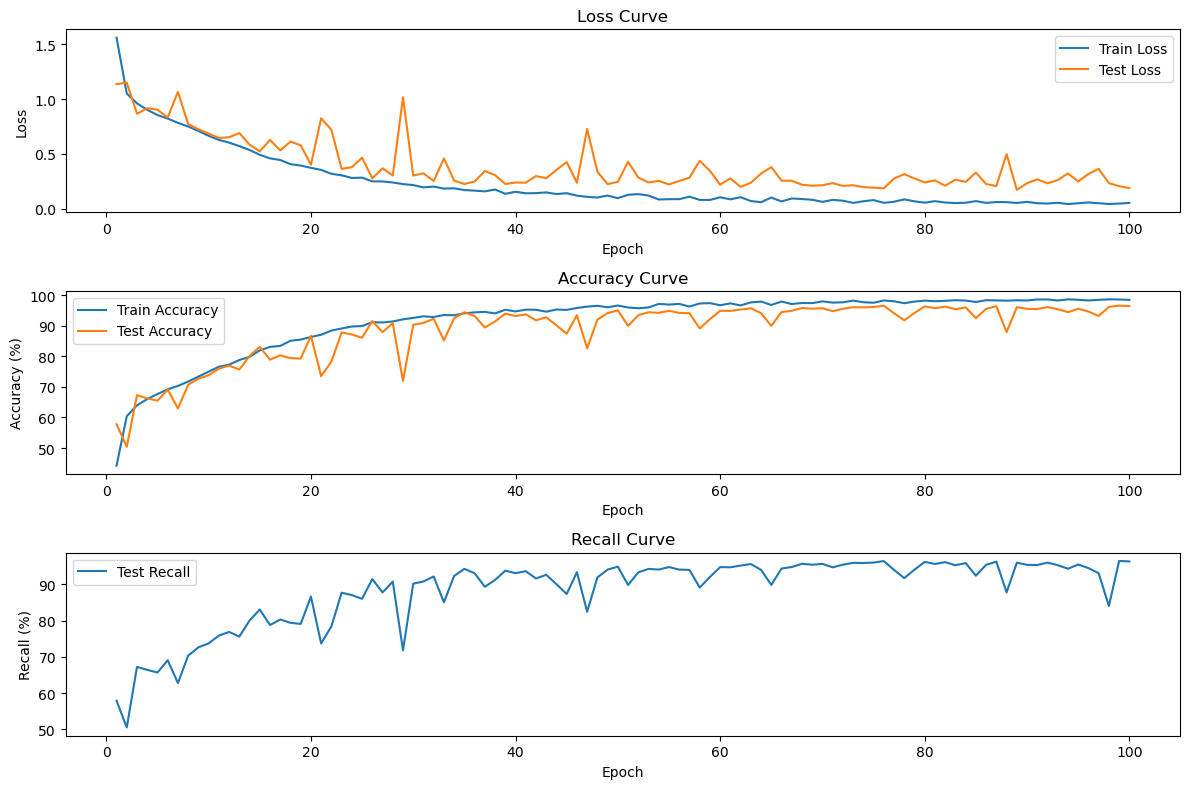

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score

# Set the device for training (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
num_classes = len(set(labels))
resnet_model = WeightedResnet(in_channels=3, num_classes=num_classes).to(device)
clinical_nn = ClinicalNN(input_dim=X_train_clin.shape[1], num_classes=num_classes).to(device)
combined_model = BilinearFusion(image_model=resnet_model, clinical_model=clinical_nn, num_classes=num_classes).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(combined_model.parameters(), lr=0.001)

# DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Number of epochs
num_epochs = 100

# Lists to store metrics
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []
test_recalls = []

# Training loop with tqdm and GPU support
for epoch in range(1, num_epochs + 1):
    combined_model.train()  # Set the model to training mode
    running_train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Train the model
    for batch in tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs}", ncols=100):
        images = batch["image"].to(device)
        clinical_data = batch["clinical_data"].to(device)
        labels = batch["label"].to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = combined_model(images, clinical_data)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        running_train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)
    
    # Compute average training loss and accuracy for the epoch
    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = correct_train / total_train * 100

    # Evaluate on test set
    combined_model.eval()  # Set the model to evaluation mode
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_labels, all_predictions = [], []
    
    with torch.no_grad():  # No need to compute gradients during evaluation
        for batch in test_loader:
            images = batch["image"].to(device)
            clinical_data = batch["clinical_data"].to(device)
            labels = batch["label"].to(device)

            # Forward pass
            outputs = combined_model(images, clinical_data)
            
            # Compute loss
            loss = criterion(outputs, labels)
            running_test_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

            # Collect labels and predictions for recall computation
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    
    # Compute average test loss and accuracy
    avg_test_loss = running_test_loss / len(test_loader)
    test_accuracy = correct_test / total_test * 100
    test_recall = recall_score(all_labels, all_predictions, average="macro") * 100

    # Store metrics for plotting
    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    test_recalls.append(test_recall)

    # Print metrics
    print(f"Epoch {epoch}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%, Test Recall: {test_recall:.2f}%")


# Plot metrics
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 8))

# Loss curve
plt.subplot(3, 1, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Accuracy curve
plt.subplot(3, 1, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

# Recall curve
plt.subplot(3, 1, 3)
plt.plot(epochs, test_recalls, label="Test Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall (%)")
plt.title("Recall Curve")
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
torch.save(combined_model, "FinalWeights/BilinearFusionWeights.pt")

In [5]:
class_names = classnames 

Original Classnames:
0: Benign lesions of the keratosis
1: Basal cell carcinoma
2: Dermatofibroma
3: Melanoma
4: Melanocylabels
5: tic nevi
6: Vascular lesions
7: Actinic keratoses


C:\Users\dasad\AppData\Local\Temp\ipykernel_17864\2886630374.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model = torch.load("FinalWeights/BilinearFusionWeigh

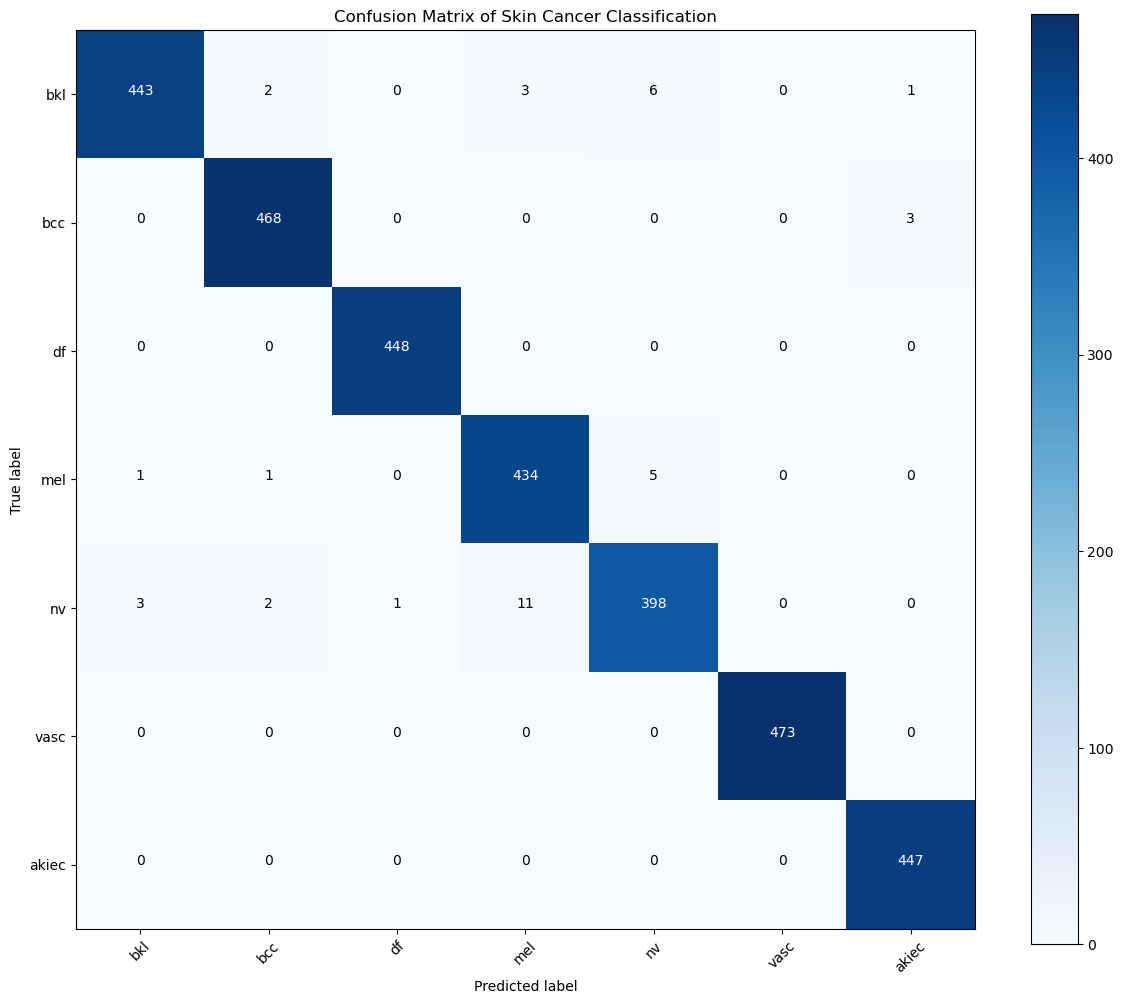

Test Data Classification Report:
               precision    recall  f1-score   support

         bkl     0.9911    0.9736    0.9823       455
         bcc     0.9894    0.9936    0.9915       471
          df     0.9978    1.0000    0.9989       448
         mel     0.9688    0.9841    0.9764       441
          nv     0.9731    0.9590    0.9660       415
        vasc     1.0000    1.0000    1.0000       473
       akiec     0.9911    1.0000    0.9955       447

    accuracy                         0.9876      3150
   macro avg     0.9873    0.9872    0.9872      3150
weighted avg     0.9876    0.9876    0.9876      3150


Training Data Classification Report:
               precision    recall  f1-score   support

         bkl     0.9893    0.9804    0.9848      2545
         bcc     0.9953    0.9953    0.9953      2529
          df     0.9992    1.0000    0.9996      2552
         mel     0.9719    0.9863    0.9791      2559
          nv     0.9862    0.9648    0.9754      2585
     

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Print out the original classnames to verify
print("Original Classnames:")
for i, name in enumerate(classnames):
    print(f"{i}: {name}")

# Corrected label dictionary to match exact class names
label_dict = {
    "bkl": "Benign lesions of the keratosis",
    "bcc": "Basal cell carcinoma", 
    "df": "Dermatofibroma", 
    "mel": "Melanoma", 
    "nv": "Melanocytic nevi", 
    "vasc": "Vascular lesions", 
    "akiec": "Actinic keratoses"
}

# Reverse the dictionary for abbreviation lookup
abbrev_dict = {v: k for k, v in label_dict.items()}

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model = torch.load("FinalWeights/BilinearFusionWeights.pt").to(device)
loaded_model.eval()

# Prepare to collect predictions and true labels
all_preds = []
all_labels = []

# Collect predictions
with torch.no_grad():
    for batch in test_loader:
        images = batch["image"].to(device)
        clinical_data = batch["clinical_data"].to(device)
        labels = batch["label"].to(device)
        
        outputs = loaded_model(images, clinical_data)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Prepare class names and abbreviations
# Directly use the original classnames list
class_names = classnames
class_abbrevs = list(label_dict.keys())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix of Skin Cancer Classification')
plt.colorbar()

# Add text annotations
tick_marks = np.arange(len(class_abbrevs))
plt.xticks(tick_marks, class_abbrevs, rotation=45)
plt.yticks(tick_marks, class_abbrevs)

# Add text values in each cell
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Compute classification report
report = classification_report(
    all_labels, 
    all_preds, 
    target_names=class_abbrevs,
    digits=4
)
print("Test Data Classification Report:\n", report)

# Same for training data
train_preds = []
train_labels = []

with torch.no_grad():
    for batch in train_loader:
        images = batch["image"].to(device)
        clinical_data = batch["clinical_data"].to(device)
        labels = batch["label"].to(device)
        
        outputs = loaded_model(images, clinical_data)
        _, preds = torch.max(outputs, 1)
        
        train_preds.extend(preds.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

# Convert to numpy arrays
train_preds = np.array(train_preds)
train_labels = np.array(train_labels)

# Compute training classification report
train_report = classification_report(
    train_labels, 
    train_preds, 
    target_names=class_abbrevs,
    digits=4
)
print("\nTraining Data Classification Report:\n", train_report)

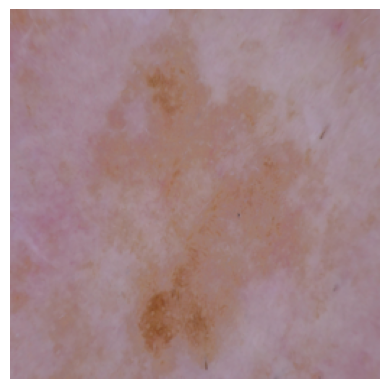

Clinical Data:
    Age    Dx Type      Sex      Localization
0  75.0  Follow-up  Unknown  Abdomen, Genital

Prediction Probabilities:
Benign lesions of the keratosis: 1.0000
Basal cell carcinoma: 0.0000
Dermatofibroma: 0.0000
Melanoma: 0.0000
Melanocytic nevi: 0.0000
Vascular lesions: 0.0000
Actinic keratoses: 0.0000

Actual Class: Benign lesions of the keratosis
Predicted Class: Benign lesions of the keratosis


In [12]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Select a random index from the test set
random_idx = np.random.randint(0, len(test_dataset))

# Get the sample
sample = test_dataset[random_idx]

# Get the image and clinical data
image = sample['image'].unsqueeze(0).to(device)  # Add batch dimension
clinical_data = sample['clinical_data'].unsqueeze(0).to(device)  # Add batch dimension
actual_label = sample['label']

# Get the clinical data as a DataFrame (for better display)
clinical_data_dict = sample['clinical_data'].cpu().numpy()

# Determine the dx_type based on the columns 'dx_type_confocal', 'dx_type_consensus', and 'dx_type_follow_up'
dx_type = ''
if clinical_data_dict[0] == 1:
    dx_type = 'Confocal'
elif clinical_data_dict[1] == 1:
    dx_type = 'Consensus'
elif clinical_data_dict[2] == 1:
    dx_type = 'Follow-up'

# Determine the sex based on the 'sex_female' and 'sex_male' columns
sex = ''
if clinical_data_dict[4] == 1:
    sex = 'Female'
elif clinical_data_dict[5] == 1:
    sex = 'Male'
else:
    sex = 'Unknown'

# Determine the localization (only the body part where lesion is located is shown)
localization = []
local_columns = [
    'local_abdomen', 'local_acral', 'local_back', 'local_chest', 'local_ear', 'local_face', 'local_foot',
    'local_genital', 'local_hand', 'local_lower extremity', 'local_neck', 'local_scalp', 'local_trunk',
    'local_unknown', 'local_upper extremity'
]
for i, loc in enumerate(local_columns):
    if clinical_data_dict[i + 6] == 1:  # Skip the first 6 columns for dx_type and sex
        localization.append(loc.replace('local_', '').replace('_', ' ').capitalize())

# Create the DataFrame
clinical_df = pd.DataFrame([{
    'Age': clinical_data_dict[0],
    'Dx Type': dx_type,
    'Sex': sex,
    'Localization': ', '.join(localization) if localization else 'Unknown'
}], columns=['Age', 'Dx Type', 'Sex', 'Localization'])

# Get the prediction from the combined model
combined_model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = combined_model(image, clinical_data)

# Get the probabilities of each class
probs = torch.softmax(output, dim=1).cpu().numpy().flatten()

# Define the class names based on your dataset
class_names = [
    'Benign lesions of the keratosis', 
    'Basal cell carcinoma', 
    'Dermatofibroma', 
    'Melanoma', 
    'Melanocytic nevi', 
    'Vascular lesions', 
    'Actinic keratoses'
]

# Get the predicted class
predicted_class = np.argmax(probs)

# Plot the image
plt.imshow(sample['image'].permute(1, 2, 0))  # Change from [C, H, W] to [H, W, C]
plt.axis('off')  # Hide axes
plt.show()

# Display the clinical data
print("Clinical Data:")
print(clinical_df)

# Display the prediction probabilities for each class
print("\nPrediction Probabilities:")
for idx, class_name in enumerate(class_names):
    print(f"{class_name}: {probs[idx]:.4f}")

# Display the actual class and predicted class
print("\nActual Class:", class_names[actual_label])
print("Predicted Class:", class_names[predicted_class])


In [13]:
clinical_df

Age    Dx Type      Sex      Localization
0  75.0  Follow-up  Unknown  Abdomen, Genital

In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch.nn.functional as F
import seaborn as sns
import pandas as pd

class ModelVisualizer:
    def __init__(self, model_path, device='cuda'):
        self.device = device
        self.model = torch.load(model_path).to(device)
        self.model.eval()
        
        # Define clinical feature names
        self.clinical_feature_names = [
            "Age",
            "Dx Type: Confocal",
            "Dx Type: Consensus",
            "Dx Type: Follow-Up",
            "Dx Type: Histopathology",
            "Sex: Female",
            "Sex: Male",
            "Sex: Unknown",
            "Localization: Abdomen",
            "Localization: Acral",
            "Localization: Back",
            "Localization: Chest",
            "Localization: Ear",
            "Localization: Face",
            "Localization: Foot",
            "Localization: Genital",
            "Localization: Hand",
            "Localization: Lower Extremity",
            "Localization: Neck",
            "Localization: Scalp",
            "Localization: Trunk",
            "Localization: Unknown",
            "Localization: Upper Extremity"
        ]
        
    def generate_gradcam(self, image, clinical_data, target_layer_name='conv5'):
        """
        Generate smooth Grad-CAM visualization for the image pathway
        """
        # Register hooks for the target layer
        activation = None
        gradients = None
        
        def save_activation(module, input, output):
            nonlocal activation
            activation = output
            
        def save_gradient(module, grad_input, grad_output):
            nonlocal gradients
            gradients = grad_output[0]
        
        # Find target layer
        target_layer = None
        for name, module in self.model.image_model.named_modules():
            if name == target_layer_name:
                target_layer = module
                break
                
        if target_layer is None:
            raise ValueError(f"Layer {target_layer_name} not found")
            
        # Register hooks
        handle1 = target_layer.register_forward_hook(save_activation)
        handle2 = target_layer.register_backward_hook(save_gradient)
        
        # Forward pass
        image_tensor = image.unsqueeze(0).to(self.device)
        clinical_tensor = torch.tensor(clinical_data, dtype=torch.float32).unsqueeze(0).to(self.device)
        
        output = self.model(image_tensor, clinical_tensor)
        pred = output.argmax(dim=1)
        
        # Backward pass
        self.model.zero_grad()
        output[0, pred].backward()
        
        # Remove hooks
        handle1.remove()
        handle2.remove()
        
        # Generate CAM
        weights = gradients.mean(dim=(2, 3))
        cam = (weights.unsqueeze(-1).unsqueeze(-1) * activation).sum(dim=1)
        cam = F.relu(cam)
        
        # Normalize and resize
        cam = F.interpolate(cam.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False)
        cam = cam.squeeze().cpu().detach().numpy()
        
        # Apply Gaussian blur for smoothness
        cam = cv2.GaussianBlur(cam, (15, 15), 10)
        
        # Normalize to [0, 1]
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        
        return cam
    
    def generate_clinical_importance(self, clinical_data):
        """
        Generate feature importance visualization for clinical pathway
        """
        # Get weights from the first layer of clinical model
        weights = self.model.clinical_model.fc1.weight.detach().cpu().numpy()
        
        # Calculate feature importance as L1 norm of weights
        importance = np.abs(weights).mean(axis=0)
        
        # Normalize importance scores
        importance = (importance - importance.min()) / (importance.max() - importance.min() + 1e-8)
        
        return importance
    
    def visualize(self, image, clinical_data, class_names):
        """
        Generate comprehensive visualization
        """
        # Generate attributions
        cam = self.generate_gradcam(image, clinical_data)
        clinical_importance = self.generate_clinical_importance(clinical_data)
        
        # Create visualization
        fig = plt.figure(figsize=(20, 12))
        
        # Plot original image
        ax1 = plt.subplot(2, 2, 1)
        plt.imshow(image.permute(1, 2, 0).cpu())
        plt.title('Original Image', fontsize=12, pad=10)
        plt.axis('off')
        
        # Plot Grad-CAM
        ax2 = plt.subplot(2, 2, 2)
        plt.imshow(image.permute(1, 2, 0).cpu())
        plt.imshow(cam, cmap='jet', alpha=0.5)
        plt.title('Grad-CAM Visualization', fontsize=12, pad=10)
        plt.axis('off')
        
        # Plot clinical feature importance
        ax3 = plt.subplot(2, 1, 2)
        importance_df = pd.DataFrame({
            'Feature': self.clinical_feature_names,
            'Importance': clinical_importance
        })
        importance_df = importance_df.sort_values('Importance', ascending=True)
        
        sns.barplot(data=importance_df, y='Feature', x='Importance', 
                   palette='viridis', ax=ax3)
        plt.title('Clinical Feature Importance', fontsize=12, pad=10)
        
        # Adjust layout for better readability
        ax3.set_xlabel('Relative Importance', fontsize=10)
        ax3.set_ylabel('Clinical Features', fontsize=10)
        ax3.tick_params(axis='both', which='major', labelsize=8)
        
        plt.tight_layout()
        return fig
    
    def get_prediction(self, image, clinical_data):
        """
        Get model prediction and confidence
        """
        with torch.no_grad():
            image_tensor = image.unsqueeze(0).to(self.device)
            clinical_tensor = torch.tensor(clinical_data, 
                                        dtype=torch.float32).unsqueeze(0).to(self.device)
            
            output = self.model(image_tensor, clinical_tensor)
            probabilities = F.softmax(output, dim=1)
            
            pred_class = torch.argmax(probabilities).item()
            confidence = probabilities[0][pred_class].item()
            
        return pred_class, confidence

def plot_sample_predictions(visualizer, test_loader, class_names, num_samples=5):
    """
    Plot sample predictions with visualizations
    """
    samples = []
    for batch in test_loader:
        if len(samples) >= num_samples:
            break
        samples.extend([(batch['image'][i], 
                        batch['clinical_data'][i], 
                        batch['label'][i]) 
                       for i in range(len(batch['label']))])
    
    samples = samples[:num_samples]
    
    for image, clinical_data, true_label in samples:
        pred_class, confidence = visualizer.get_prediction(image, clinical_data)
        
        fig = visualizer.visualize(image, clinical_data, class_names)
        
        plt.suptitle(f'True: {class_names[true_label]}\n' \
                    f'Predicted: {class_names[pred_class]} ' \
                    f'(Confidence: {confidence:.2f})', 
                    y=1.02, fontsize=14)
        plt.show()

C:\Users\dasad\AppData\Local\Temp\ipykernel_17252\301255111.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model = torch.load(model_path).to(device)
C:\Users\dasa

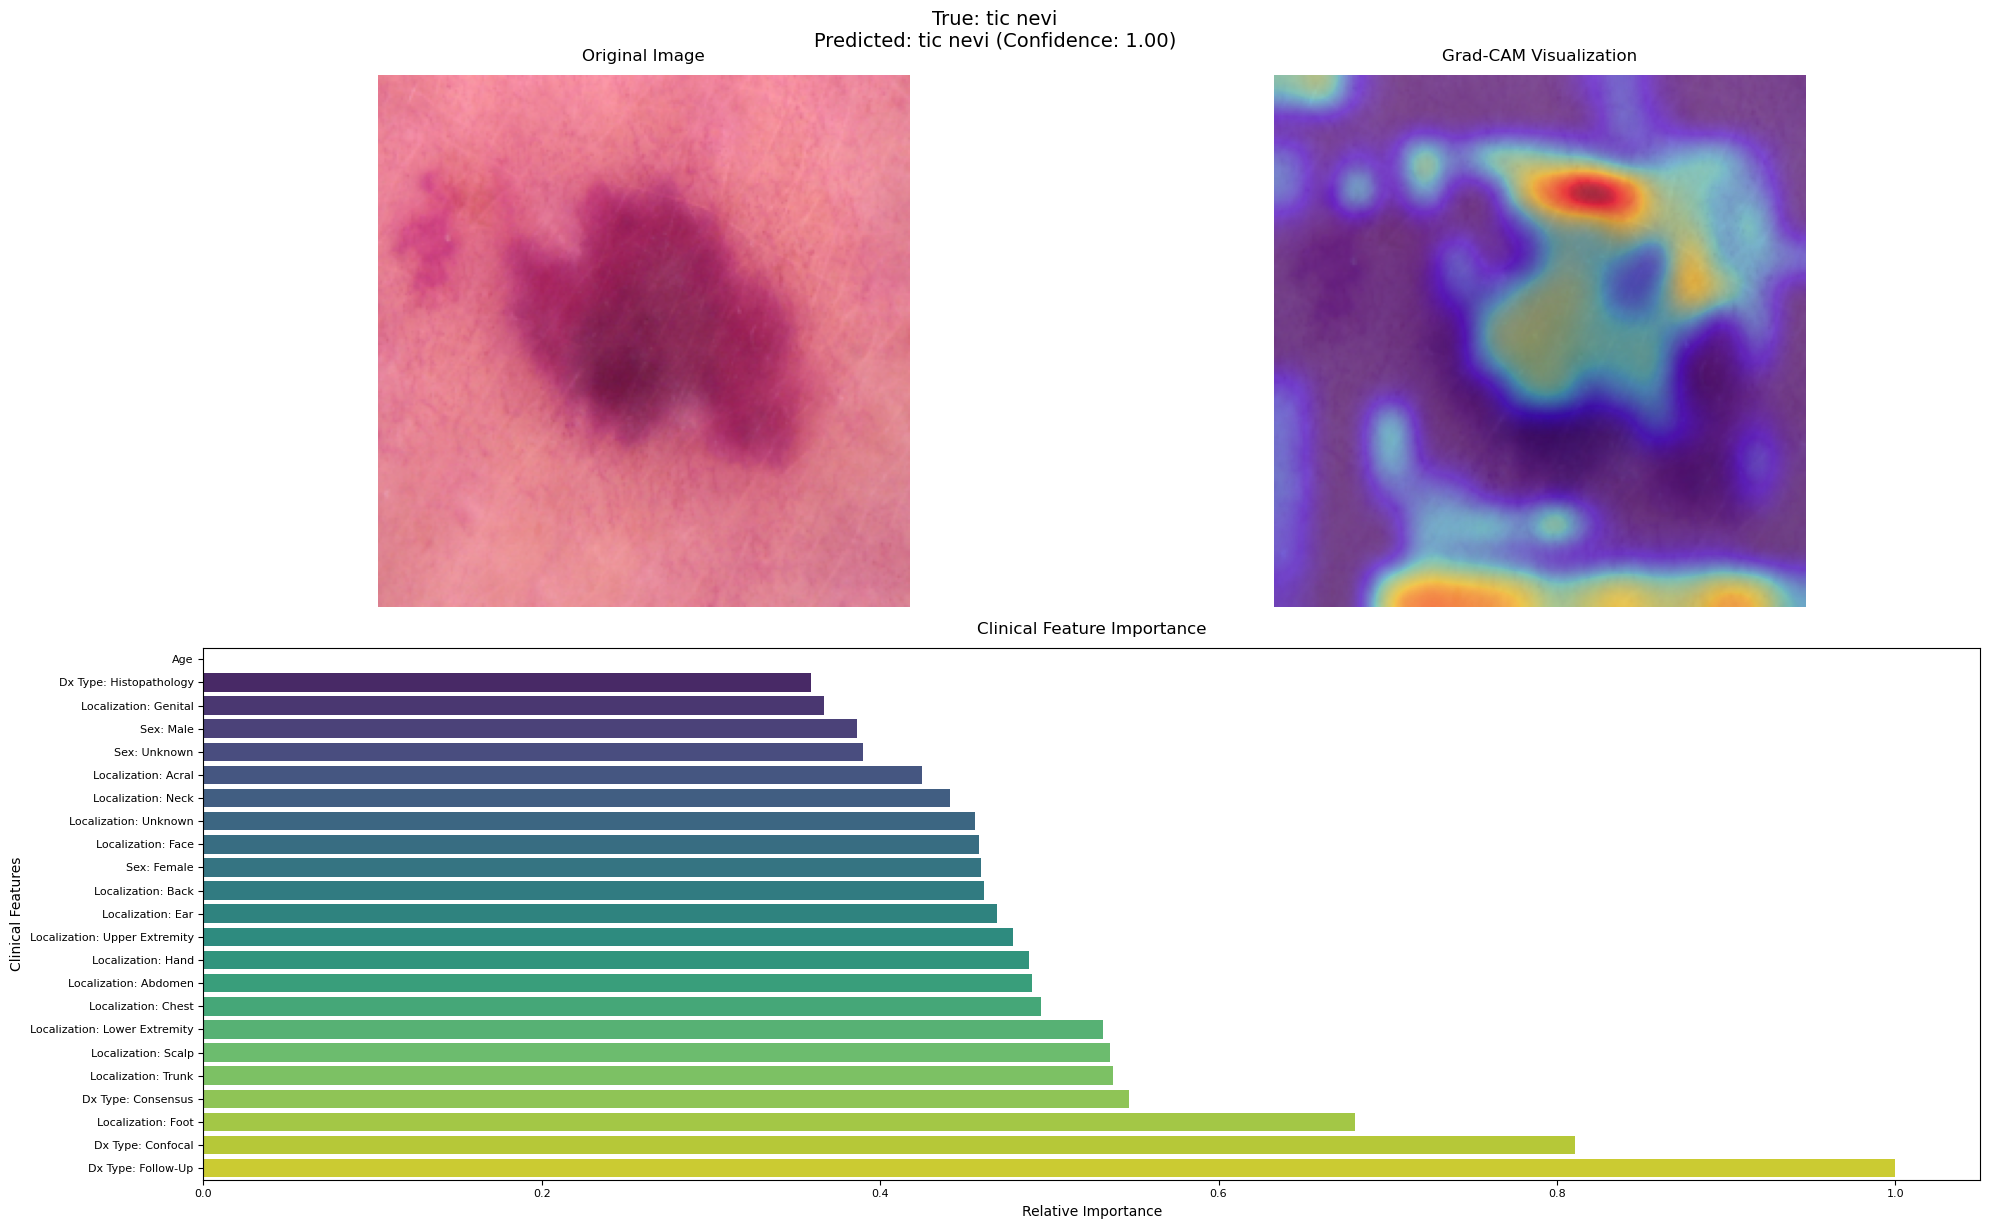

C:\Users\dasad\AppData\Local\Temp\ipykernel_17252\301255111.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data,
C:\Users\dasad\AppData\Local\Temp\ipykernel_17252\301255111.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data, dtype=torch.float32).unsqueeze(0).to(self.device)
C:\Users\dasad\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook 

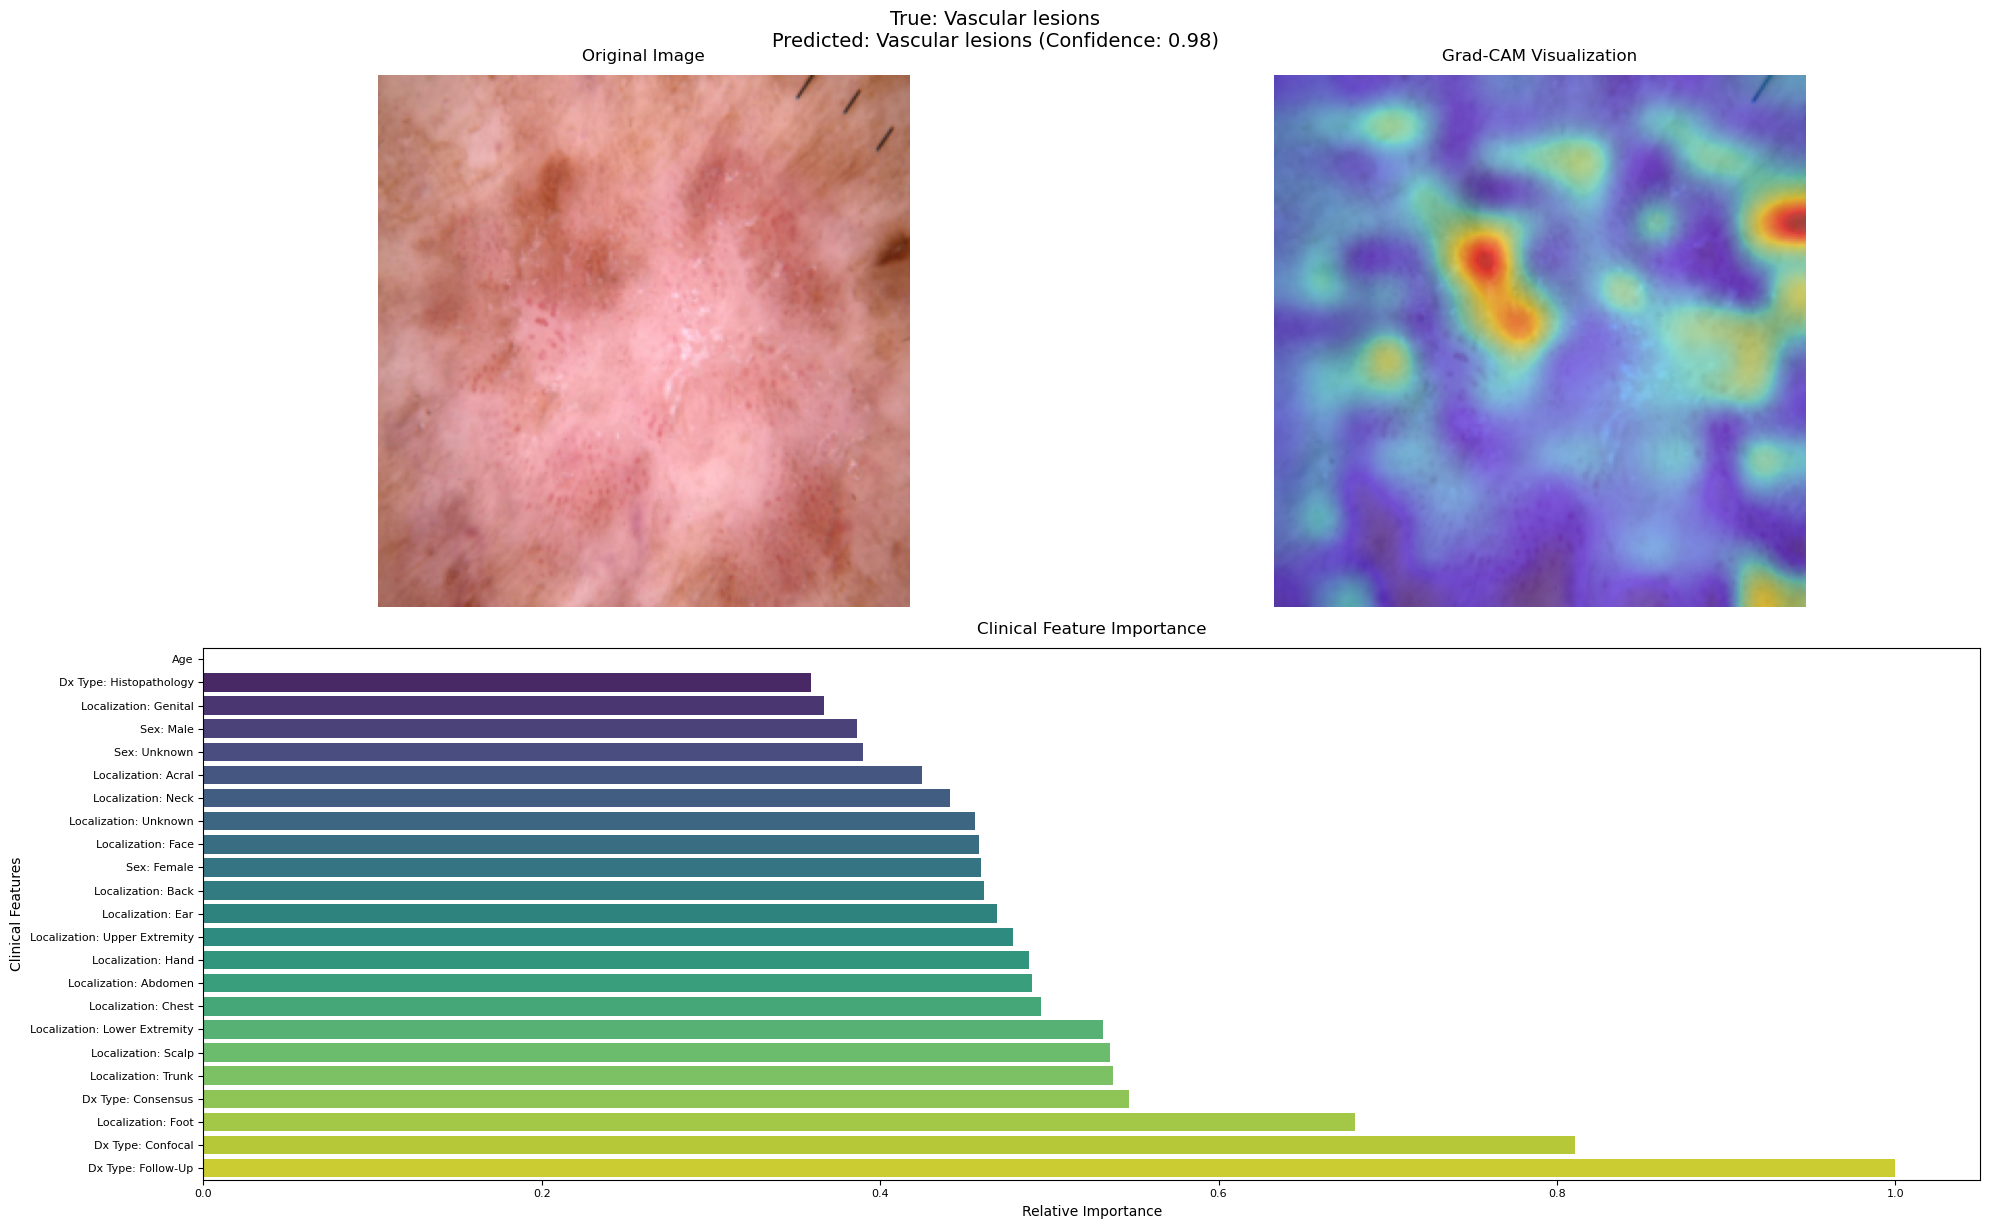

C:\Users\dasad\AppData\Local\Temp\ipykernel_17252\301255111.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data,
C:\Users\dasad\AppData\Local\Temp\ipykernel_17252\301255111.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data, dtype=torch.float32).unsqueeze(0).to(self.device)
C:\Users\dasad\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook 

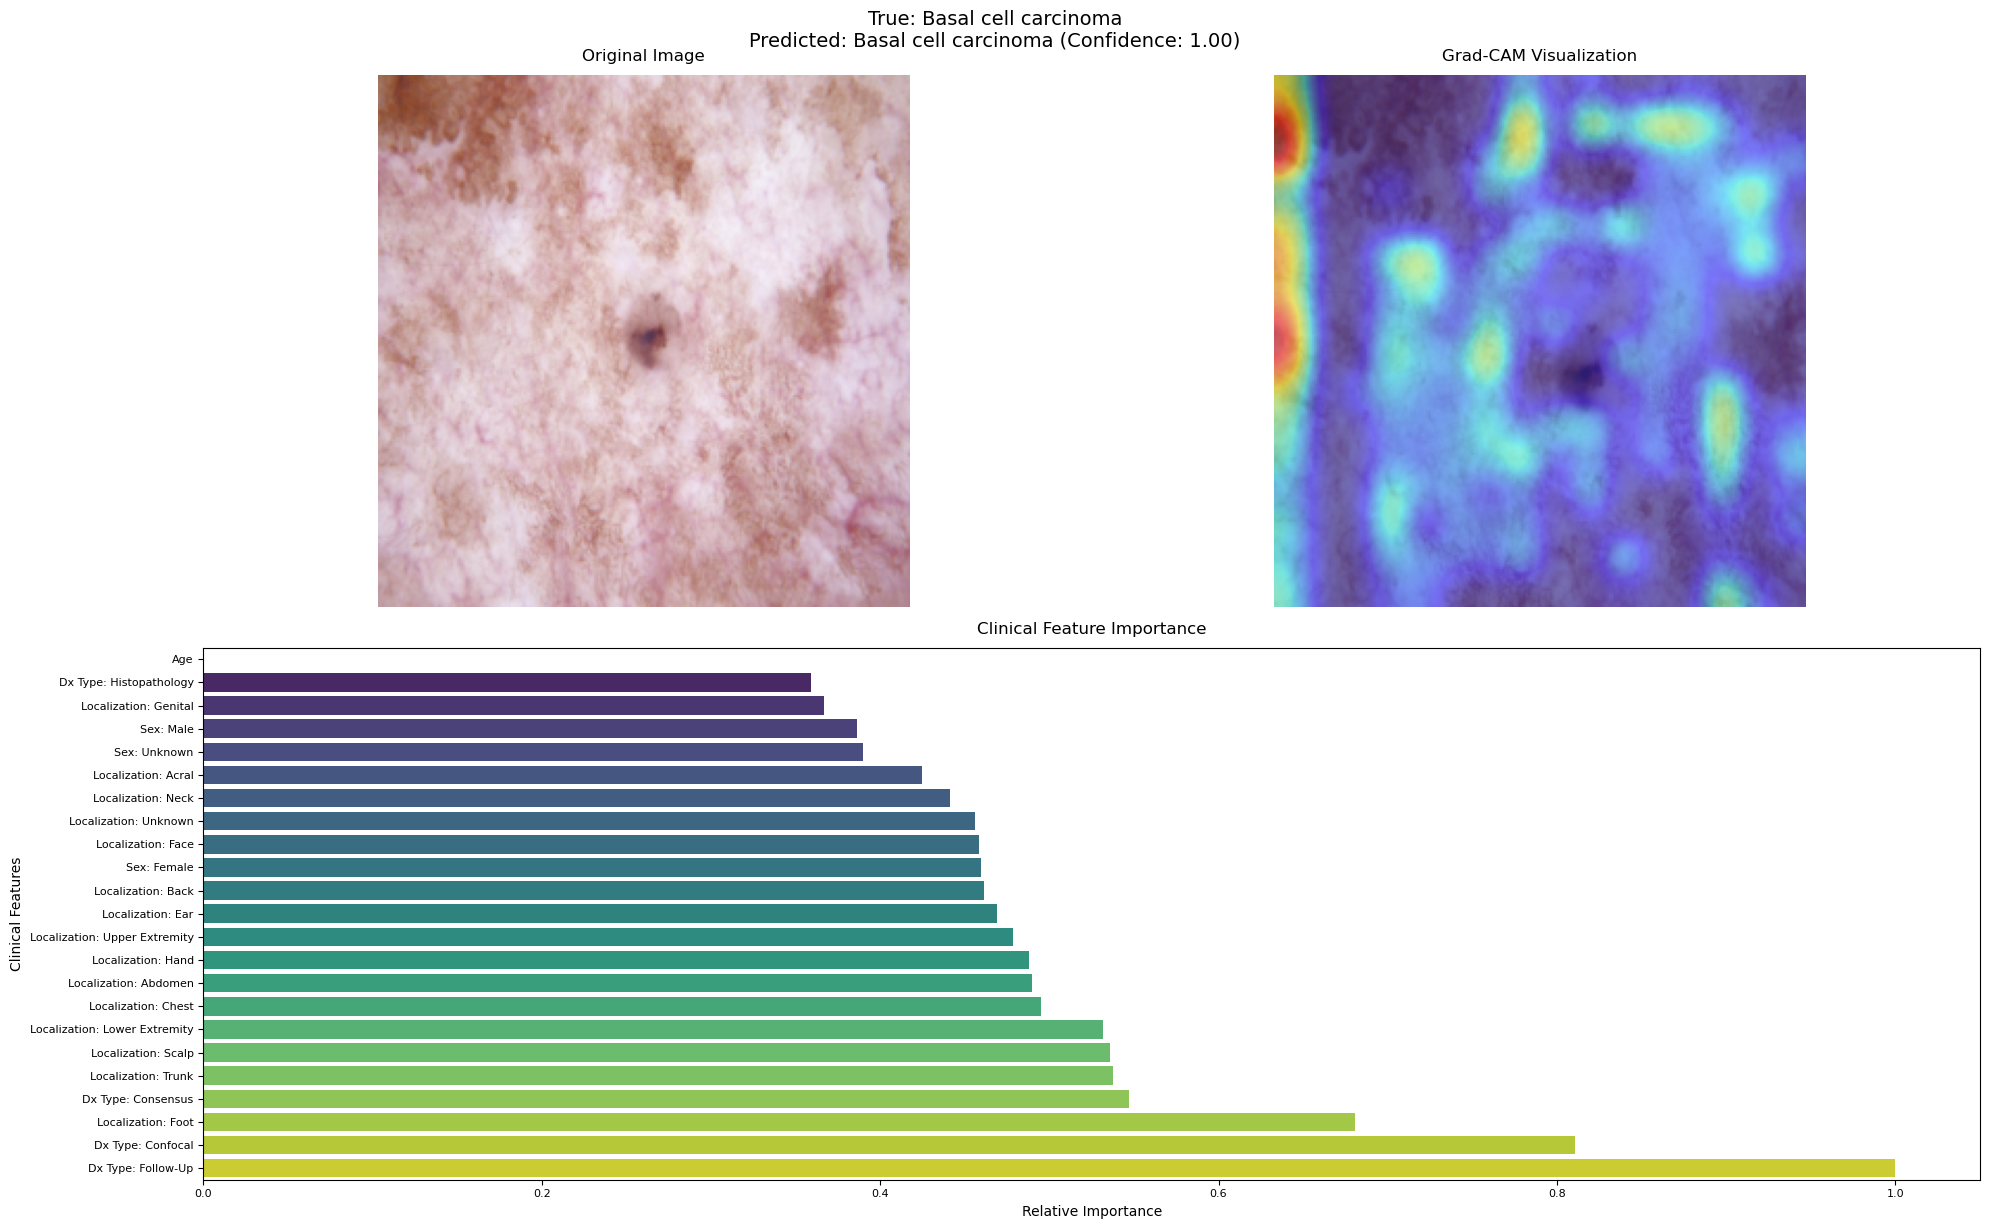

C:\Users\dasad\AppData\Local\Temp\ipykernel_17252\301255111.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data,
C:\Users\dasad\AppData\Local\Temp\ipykernel_17252\301255111.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data, dtype=torch.float32).unsqueeze(0).to(self.device)
C:\Users\dasad\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook 

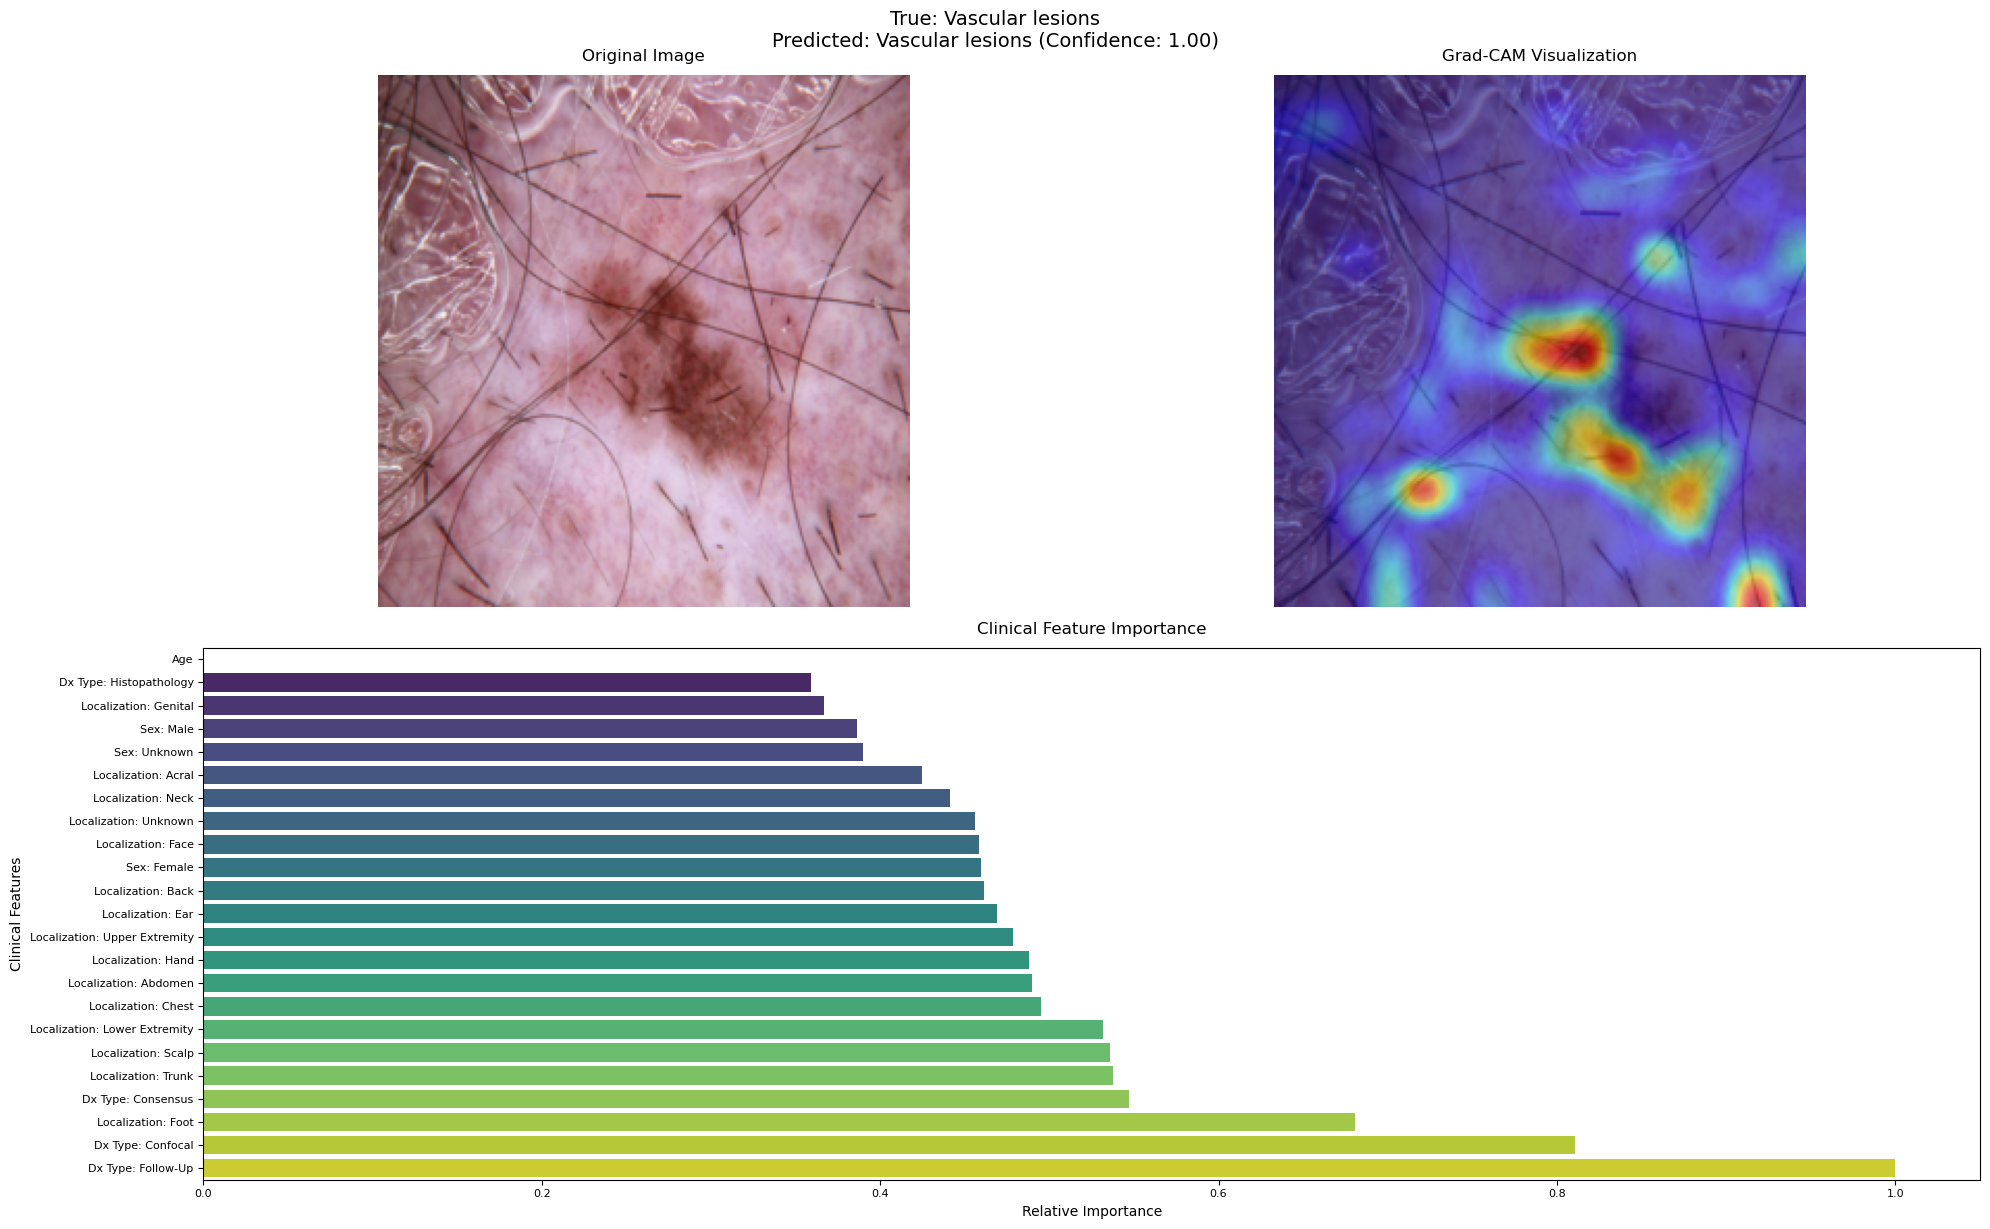

C:\Users\dasad\AppData\Local\Temp\ipykernel_17252\301255111.py:171: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data,
C:\Users\dasad\AppData\Local\Temp\ipykernel_17252\301255111.py:76: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  clinical_tensor = torch.tensor(clinical_data, dtype=torch.float32).unsqueeze(0).to(self.device)
C:\Users\dasad\AppData\Roaming\Python\Python311\site-packages\torch\nn\modules\module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook 

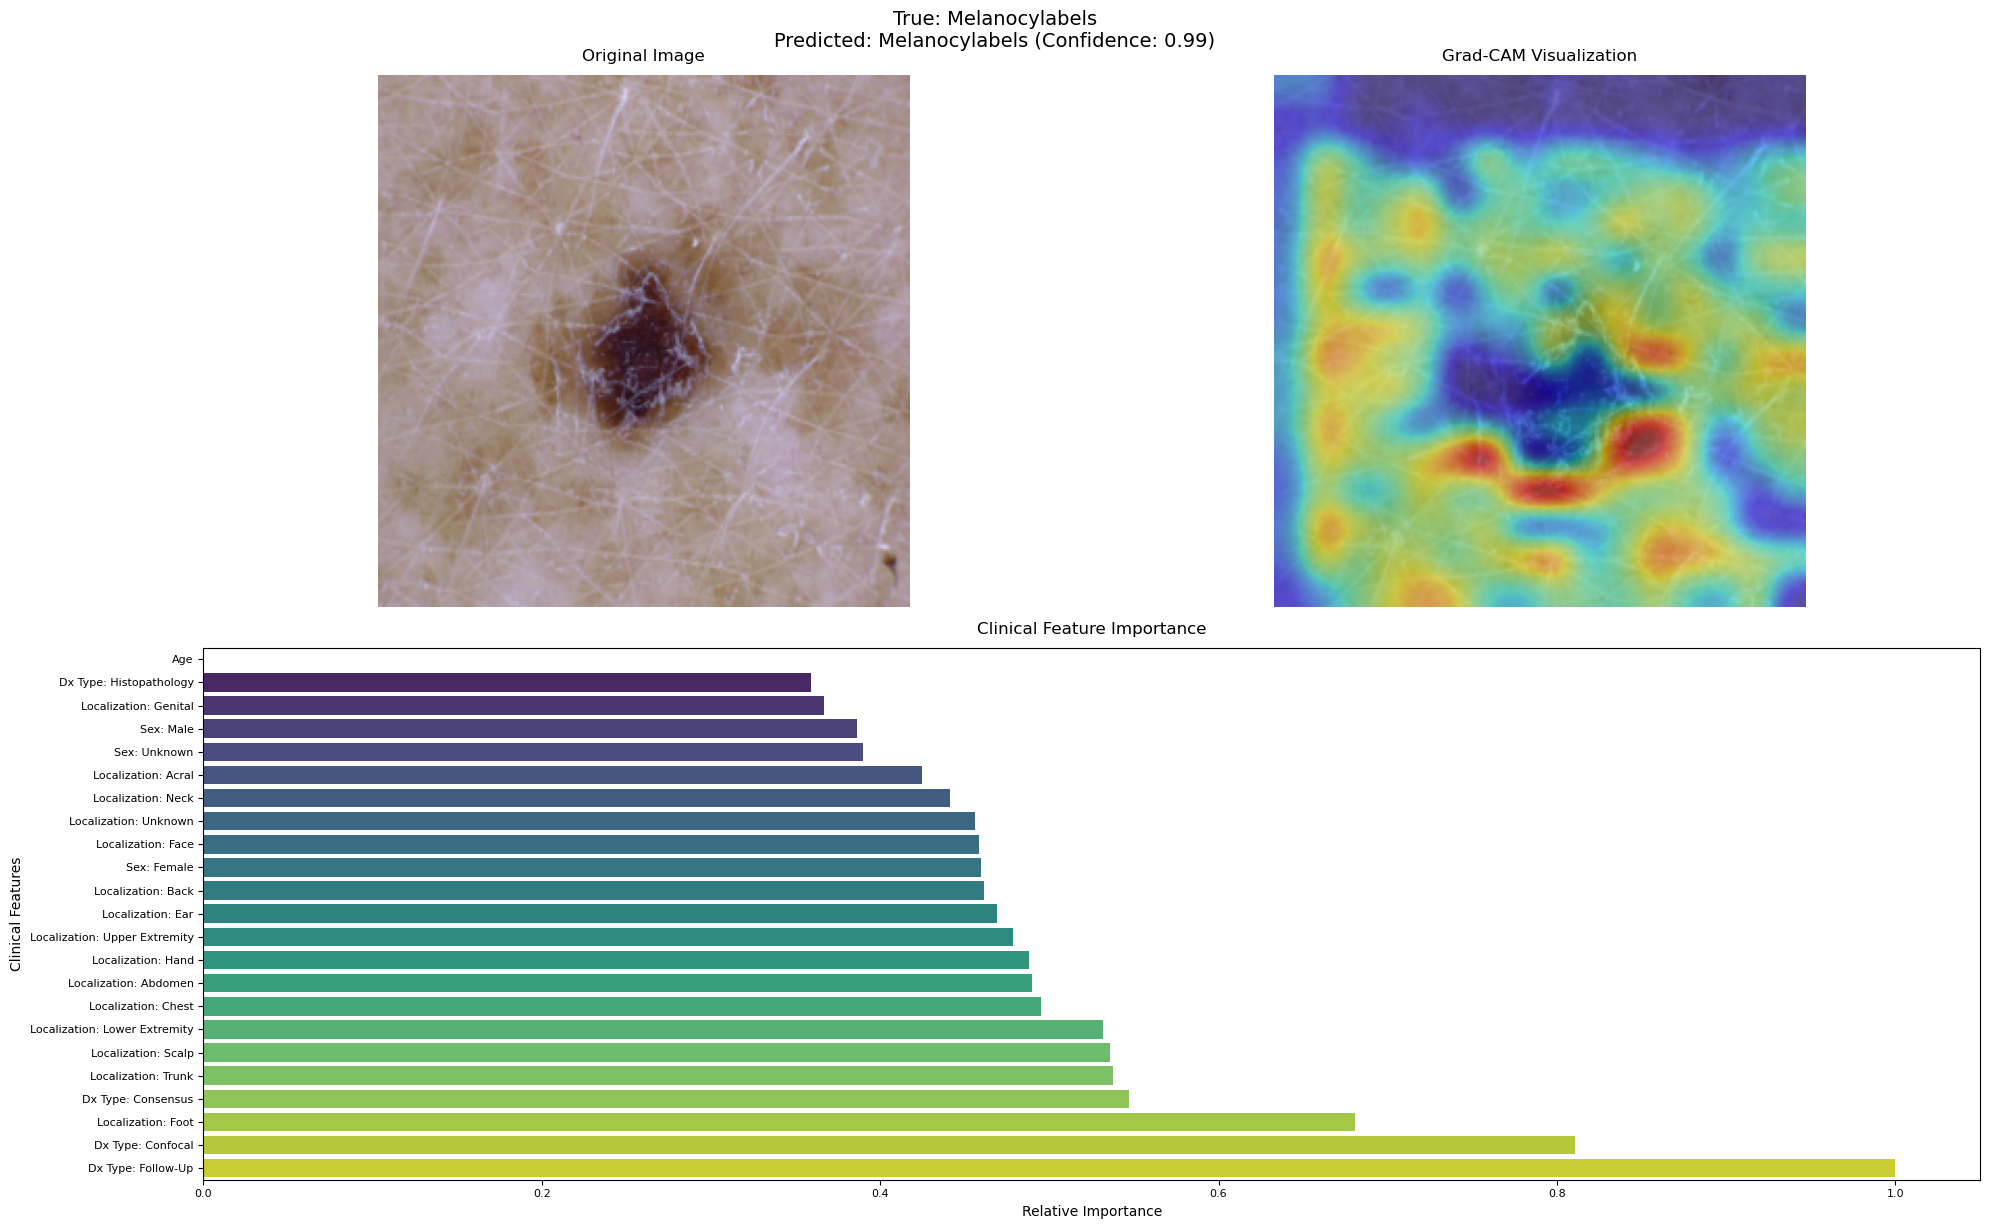

In [8]:
# Initialize the visualizer
visualizer = ModelVisualizer("BilinearFusionnFull.pt")

# Generate visualizations for sample predictions
plot_sample_predictions(visualizer, test_loader, classnames)